# League of Legend 승리 예측
출발: 리그 오브 레전드의 승리와 패배에 직접적으로 연관이 있는 정보를 데이터화 시켜서 승리할지 패배할지를 예측하는 프로그램을 만들고 싶었습니다

역할분담: 


우동관 - 데이터수집  
          박선우 - 전반적인 코드 작성 및 모델링 구상

# 1. 데이터 가져오기

데이터 출처 - https://developer.riotgames.com/
유저의 승패에 관한 정보를 데이터화 시킴

데이터가 전부 저장이 되고 나면 오류를 출력시킴 

In [14]:
# 데이터 가져오기

import time
import requests
from urllib import parse

summonerName = "SORAYAMA"; #검색할 닉네임
DEVELOPMENTAPIKEY = "RGAPI-4bbcb5b9-278b-4fb1-9065-973790af8365"; #API사용을 위한 키
encodingSummonerName = parse.quote(summonerName); #url에 넣기 위해 인코딩
APIURL = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/" + encodingSummonerName;
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com",
    "X-Riot-Token": DEVELOPMENTAPIKEY
    };
res = requests.get(APIURL, headers=headers).json();
puuid = res['puuid']; #가져온 플레이어의 puuid

APIURL = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/" + puuid + "/ids?start=0&count=100";
matchesId = requests.get(APIURL, headers=headers).json(); #해당 플레이어의 최근 100게임의 아이디

matches = [];
foundGameCount = 0;
gameDuration = [];
wins = []; #최근 100판 승패
kills = []; #최근 100판 킬수
deaths = []; #최근 100판 데스
assists = []; #최근 100판 어시스트
goldEarned = []; #최근 100판 골드 수급량
totalDamageDealtToChampions = []; #최근 100판 딜량

for matcheId  in matchesId:            
    APIURL = "https://asia.api.riotgames.com/lol/match/v5/matches/" + matcheId;
    res = requests.get(APIURL, headers=headers).json();
    
    matches.append(res);
    gameDuration.append(int(res['info']['gameDuration'] / 1000 / 60));
    
    for participant in res['info']['participants']:
        if(participant['summonerName'] == summonerName):
            wins.append(participant['win']);
            assists.append(participant['assists']);
            deaths.append(participant['deaths']);
            kills.append(participant['kills']);
            goldEarned.append(participant['goldEarned']);
            totalDamageDealtToChampions.append(participant['totalDamageDealtToChampions']);
            
    foundGameCount += 1;

KeyError: 'info'

# 2. pandas 활용

정보를 필요한 부분만 사용해 데이터화 시켰습니다 

(gameDuration(min), wins, kills, deaths, assists, goldEarned, totalDamageDealtToChampions 사용)


데이터를 불러와 데이터 확인

In [15]:
import pandas as pd
print(foundGameCount)

df = pd.DataFrame({
    'gameDuration(min)': gameDuration,
    'wins': wins,
    'kills': kills,
    'deaths': deaths,
    'assists': assists,
    'goldEarned': goldEarned,
    'totalDamageDealtToChampions': totalDamageDealtToChampions,
}, index = pd.Index(range(foundGameCount), name='idx'));

df.to_json("datas/" + summonerName + ".json", orient='table'); #데이터 json파일로 변경

new_data = pd.read_json("datas/" + summonerName + ".json", orient='table') #데이터 불러오기
new_data #출력

10


,gameDuration(min),wins,kills,deaths,assists,goldEarned,totalDamageDealtToChampions
idx,,,,,,,
0,35,True,10,6,11,12830,19548
1,45,False,8,12,6,17423,27634
2,27,False,2,15,8,7493,7863
3,32,True,8,10,16,13499,21944
4,9,True,5,4,20,8010,9622
5,15,False,1,11,13,9241,11384
6,10,False,0,0,0,1550,0
7,34,False,6,12,8,11970,19685
8,28,True,6,9,15,9693,15917


In [73]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

data_dir = "datas"
summonerNames = os.listdir(data_dir)
df = pd.DataFrame();

for i in summonerNames:
    tmp = pd.read_json(data_dir + "/" + i, orient='table')
    df = pd.concat([df, tmp])

print(len(df));
df.head(7)

1424


,gameDuration(min),wins,kills,deaths,assists,goldEarned,totalDamageDealtToChampions
idx,,,,,,,
0,39.0,0.0,11.0,5.0,14.0,14048.0,34290.0
1,21.0,0.0,0.0,4.0,6.0,5250.0,5428.0
2,22.0,0.0,21.0,10.0,11.0,20037.0,48778.0
3,14.0,0.0,6.0,10.0,2.0,11986.0,14727.0
4,22.0,0.0,20.0,6.0,10.0,22629.0,45809.0
5,18.0,0.0,20.0,7.0,3.0,18348.0,30241.0
6,14.0,1.0,5.0,1.0,21.0,11830.0,14879.0


In [74]:
df.dtypes

gameDuration(min)              float64
wins                           float64
kills                          float64
deaths                         float64
assists                        float64
goldEarned                     float64
totalDamageDealtToChampions    float64
dtype: object

In [75]:
target = df.pop('wins')

# 3. 모델 정의 (이진분류)

데이터셋을 나눈다음, 이진분류모델을 만들기 위해 활성화함수를 sigmoid, 손실함수를 binary_crossentropy 로 설정합니다.  

![nn](img/nn.jpg)

In [76]:
train_data, test_data, train_targets, test_targets = train_test_split(df.to_numpy(), target.to_numpy(), test_size=0.4, shuffle=
                                                                    False, random_state=1004);

In [113]:
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(): #동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다.
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,6,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) 
    model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [114]:
train_data.shape

(854, 6)

In [115]:
train_targets.shape #승리1 패배0

(854,)

In [116]:
test_targets.shape

(570,)

In [117]:
test_data.shape

(570, 6)

# 4. 데이터 정규화 과정

In [118]:
#평균을 뺀 값을 표준 편차로 나눈다

mean = train_data.mean(axis=0) #평균
train_data -= mean #평균을 뺀값
std = train_data.std(axis=0) #표준편차
train_data /= std #평균을 뺀 값을 표준편차로 나눈 값

test_data -= mean
test_data /= std

In [119]:
train_data.shape

(854, 6)

In [120]:
model = build_model()
model.fit(train_data, train_targets, epochs=30, batch_size=16)
val_mse, val_mae = model.evaluate(test_data, test_targets)
print(val_mae)

Epoch 1/30
54/54 [==============================] - 0s 888us/step - loss: 0.6311 - accuracy: 0.6382
Epoch 2/30
54/54 [==============================] - 0s 815us/step - loss: 0.5680 - accuracy: 0.7529
Epoch 3/30
54/54 [==============================] - 0s 815us/step - loss: 0.5245 - accuracy: 0.7717
Epoch 4/30
54/54 [==============================] - 0s 889us/step - loss: 0.4975 - accuracy: 0.7775
Epoch 5/30
54/54 [==============================] - 0s 889us/step - loss: 0.4815 - accuracy: 0.7775
Epoch 6/30
54/54 [==============================] - 0s 889us/step - loss: 0.4727 - accuracy: 0.7810
Epoch 7/30
54/54 [==============================] - 0s 815us/step - loss: 0.4673 - accuracy: 0.7740
Epoch 8/30
54/54 [==============================] - 0s 889us/step - loss: 0.4633 - accuracy: 0.7822
Epoch 9/30
54/54 [==============================] - 0s 889us/step - loss: 0.4581 - accuracy: 0.7869
Epoch 10/30
54/54 [==============================] - 0s 889us/step - loss: 0.4579 - accuracy: 0.7857

# 5. K겹 검증

In [86]:
x_val = model

In [87]:
import numpy as np

k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  # 검증 데이터 준비: k번째 분할
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

model = build_model()  # 케라스 모델 구성(컴파일 포함)
model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
          epochs=num_epochs, batch_size=1, verbose=0)
val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # 검증 세트로 모델 평가
all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [88]:
all_scores

[0.737089216709137]

# 6. 각 폴드에서 검증 점수를 로그에 저장하기
- 신경망을 조금 더 오래 100 에포크 동안 훈련한다.


In [90]:
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  #검증 데이터 준비: k번째 분할    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

model = build_model()  # 케라스 모델 구성(컴파일 포함)
history = model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
                    validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['val_loss']
all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [91]:
all_mae_histories

[[0.5083594918251038,
  0.4852636158466339,
  0.492437481880188,
  0.49077069759368896,
  0.49601686000823975,
  0.5012676119804382,
  0.4928840696811676,
  0.4956545829772949,
  0.49918636679649353,
  0.48838943243026733,
  0.5003462433815002,
  0.5007777810096741,
  0.507266104221344,
  0.5006011724472046,
  0.5018245577812195,
  0.49593833088874817,
  0.5185645222663879,
  0.5172644257545471,
  0.5174673199653625,
  0.5148354768753052,
  0.5177210569381714,
  0.5173794031143188,
  0.5391824245452881,
  0.5212194323539734,
  0.508018970489502,
  0.5196565985679626,
  0.5157552361488342,
  0.5377615690231323,
  0.5307638049125671,
  0.5318977236747742,
  0.5549741387367249,
  0.5545881986618042,
  0.548026442527771,
  0.5466448664665222,
  0.5646140575408936,
  0.5491489768028259,
  0.5615623593330383,
  0.5786784887313843,
  0.5784119963645935,
  0.570967435836792,
  0.5644986629486084,
  0.5731359720230103,
  0.5692771673202515,
  0.5663803815841675,
  0.5801452398300171,
  0.564741

# 7. K-겹 검증 점수 평균 기록하기

In [92]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# 8. 검증 점수 그래프

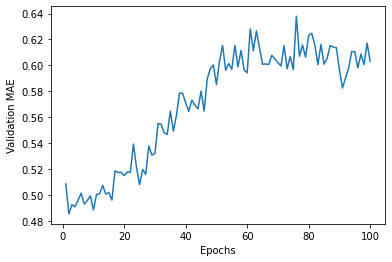

In [93]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 9. 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
- 데이터를 부드럽게 만드는 기법

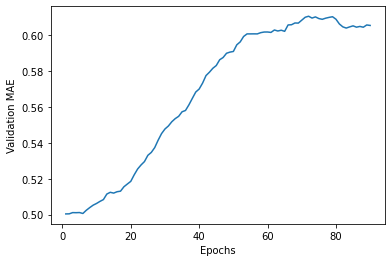

In [94]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 10. 최종 모델 훈련하기

In [95]:
model = build_model()  # 새롭게 컴파일된 모델을 얻습니다.
model.fit(train_data, train_targets,  # 전체 데이터로 훈련시킵니다.
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

18/18 [==============================] - 0s 889us/step - loss: 0.4477 - accuracy: 0.7895


In [96]:
test_mae_score

0.7894737124443054

# 11. 프로젝트를 하면서 느낀점

- 인공지능을 많이 아는 것도 아니고, 처음 다뤄보는 것이여서 처음엔 어떻게 해야할지 막막했었습니다. 잘 모르는 인공지능 분야를 선택하는 것보다 최대한 학교에서 배운 것을 써먹을 수 있는 주제를 찾았습니다.  
그럼에도 어려웠던 부분도 있었고 오류때문에 힘들었던 적도 있었으나 선생님께 자문하는 방식으로 해결방법을 얻었습니다.   
도움을 주신 선생님께 감사의 말씀을 드리고 싶고, 데이터 수집하느라 수고해준 동관이에게도 고맙다는 말을 남기고 싶습니다.  
- 오류를 조사하면서 알게된 조금더 복잡한 인공지능에 대해서 관심이 생겼고 기회가 생긴다면 더 알아보고 싶습니다.